# MC62 — LEAR C-shaped Dipole — `01_staircase_with_shims` — Rotating Coil Analysis

**Magnet**: MC62 (red bulk C-shaped dipole)
**Machine**: LEAR antiproton decelerator, CERN
**Test**: `01_staircase_with_shims` — full hysteresis staircase (2026-02-11)
**Current cycle**: 0 → +200 → 0 → −200 → 0 A in 20 A steps (41 plateaus)
**PCBs**: Integral (R45, long coil) and Central (DQ, small coil), 350 turns/plateau at −60 rpm

---
**Note on the large b2**: C-shaped dipoles have inherent left-right asymmetry (open gap
on one side, iron yoke on the other). This breaks the mid-plane symmetry that an H-dipole
would have, producing a systematic quadrupole gradient (b2) across the aperture.

## 1. Configuration

Adjust parameters below, then **Run All**.

In [1]:
from pathlib import Path

# ── Paths ──────────────────────────────────────────────────────────────
BASE_DIR    = Path(r"C:\Users\albellel\python-projects\rotating-coil-analyzer\measurements\2026_02_11_MC62")
TEST_DIR    = BASE_DIR / "01_staircase_with_shims" / "20260211_114759_staircase_MC62"
RUN_DIR     = TEST_DIR / "20260211_133720_MC62"
KN_DIR      = BASE_DIR / "Kn values"

KN_INTEGRAL = KN_DIR / "Kn_R45_PCB_N1_0001_A_AC.txt"       # integral (long) PCB
KN_CENTRAL  = KN_DIR / "Kn_DQ_5_18_7_250_47x50_0001_A_AC.txt"  # central (small) PCB

# ── Magnet & coil parameters ──────────────────────────────────────────
MAGNET_ORDER     = 1        # dipole
R_REF            = 0.033    # reference radius [m]  (2/3 of 50 mm half-gap)
SAMPLES_PER_TURN = 1024     # encoder resolution

# ── Averaging & selection ─────────────────────────────────────────────
N_LAST_TURNS = 170          # average last 170 turns (skip first 180 ≈ 10×tau for settling)

# ── Pipeline options ──────────────────────────────────────────────────
OPTIONS    = ("dri", "rot", "cel", "fed")
DRIFT_MODE = "legacy"
MIN_B1_T   = 1e-6           # warm dipole: lower threshold for ok_main
MAX_ZR     = 0.01

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

%matplotlib widget

plt.rcParams.update({
    "figure.figsize": (14, 5),
    "axes.grid": True,
    "grid.alpha": 0.3,
    "figure.dpi": 110,
})

from rotating_coil_analyzer.analysis.kn_pipeline import load_segment_kn_txt
from rotating_coil_analyzer.analysis.utility_functions import (
    process_kn_pipeline,
    build_harmonic_rows,
)
from rotating_coil_analyzer.ingest.channel_detect import robust_range

## 2. Load Kn Calibration

External Kn files — the in-test files are all zeros and are **not** used.

In [3]:
kn_integral = load_segment_kn_txt(str(KN_INTEGRAL))
kn_central  = load_segment_kn_txt(str(KN_CENTRAL))

for lbl, kn in [("Integral (R45)", kn_integral), ("Central (DQ)", kn_central)]:
    k1_abs = abs(kn.kn_abs[0])
    k1_cmp = abs(kn.kn_cmp[0])
    supp = k1_abs / max(k1_cmp, 1e-30)
    print(f"{lbl:20s}: {len(kn.orders):2d} harmonics, "
          f"k1_abs = {k1_abs:.6f}, suppression = {supp:.0f}x")

Integral (R45)      : 30 harmonics, k1_abs = 1.447495, suppression = 12924x
Central (DQ)        : 15 harmonics, k1_abs = 0.031959, suppression = 2302922349194870x


## 3. Discover and Load Raw Data

Each run is a plateau at fixed current.  Raw data columns: `[time, ch1, ch2, I_DCCT]`.
41 runs, 350 turns each, 20 A staircase: 0→+200→0→−200→0 A.
Channel detection uses `robust_range` on the highest-current run.

In [4]:
Ns = SAMPLES_PER_TURN

def discover_runs(run_dir, pcb_label):
    files = sorted(run_dir.glob(f"*_{pcb_label}_raw_measurement_data.txt"))
    runs = []
    for f in files:
        m = re.search(r'Run_(\d+)_I_([-\d.]+)A', f.name)
        if m:
            runs.append({"run_id": int(m.group(1)),
                         "I_nom": float(m.group(2)), "file": f})
    return runs

runs_integral = discover_runs(RUN_DIR, "Integral")
runs_central  = discover_runs(RUN_DIR, "Central")

print(f"Found {len(runs_integral)} integral runs, "
      f"{len(runs_central)} central runs")
print(f"Turns per run: {np.loadtxt(runs_integral[0]['file']).shape[0] // Ns}\n")
for r in runs_integral:
    print(f"  Run {r['run_id']:02d}: I = {r['I_nom']:+8.2f} A")

Found 41 integral runs, 41 central runs
Turns per run: 350

  Run 00: I =    +0.00 A
  Run 01: I =   +20.00 A
  Run 02: I =   +40.00 A
  Run 03: I =   +60.00 A
  Run 04: I =   +80.00 A
  Run 05: I =  +100.00 A
  Run 06: I =  +120.00 A
  Run 07: I =  +140.00 A
  Run 08: I =  +160.00 A
  Run 09: I =  +180.00 A
  Run 10: I =  +200.00 A
  Run 11: I =  +180.00 A
  Run 12: I =  +160.00 A
  Run 13: I =  +140.00 A
  Run 14: I =  +120.00 A
  Run 15: I =  +100.00 A
  Run 16: I =   +80.00 A
  Run 17: I =   +60.00 A
  Run 18: I =   +40.00 A
  Run 19: I =   +20.00 A
  Run 20: I =    +0.00 A
  Run 21: I =   -20.00 A
  Run 22: I =   -40.00 A
  Run 23: I =   -60.00 A
  Run 24: I =   -80.00 A
  Run 25: I =  -100.00 A
  Run 26: I =  -120.00 A
  Run 27: I =  -140.00 A
  Run 28: I =  -160.00 A
  Run 29: I =  -180.00 A
  Run 30: I =  -200.00 A
  Run 31: I =  -180.00 A
  Run 32: I =  -160.00 A
  Run 33: I =  -140.00 A
  Run 34: I =  -120.00 A
  Run 35: I =  -100.00 A
  Run 36: I =   -80.00 A
  Run 37: I =  

## 3b. Current Profile and Turn Map

Load time and DCCT current from **all** run files to build the full
measurement timeline.  Each turn is drawn as a coloured bar at its
mean current level.

In [5]:
# ── Collect per-sample time & current from all runs ────────────────────
t_all_samples = []
I_all_samples = []
turn_info = []

for run_info in runs_integral:
    raw = np.loadtxt(run_info["file"])
    n_turns = raw.shape[0] // Ns
    raw = raw[: n_turns * Ns]

    t_samp = raw[:, 0]
    I_samp = raw[:, 3]
    t_all_samples.append(t_samp)
    I_all_samples.append(I_samp)

    t_2d = t_samp.reshape(n_turns, Ns)
    I_2d = I_samp.reshape(n_turns, Ns)
    for ti in range(n_turns):
        turn_info.append({
            "t_start": t_2d[ti, 0],
            "t_end":   t_2d[ti, -1],
            "I_mean":  I_2d[ti].mean(),
            "run_id":  run_info["run_id"],
            "I_nom":   run_info["I_nom"],
            "turn_in_run": ti,
        })

t_all_samples = np.concatenate(t_all_samples)
I_all_samples = np.concatenate(I_all_samples)
df_turns = pd.DataFrame(turn_info)

print(f"Timeline: {t_all_samples[0]:.1f} – {t_all_samples[-1]:.1f} s  "
      f"({len(df_turns)} turns across {df_turns['run_id'].nunique()} runs)")

Timeline: 0.0 – 26123.6 s  (14350 turns across 41 runs)


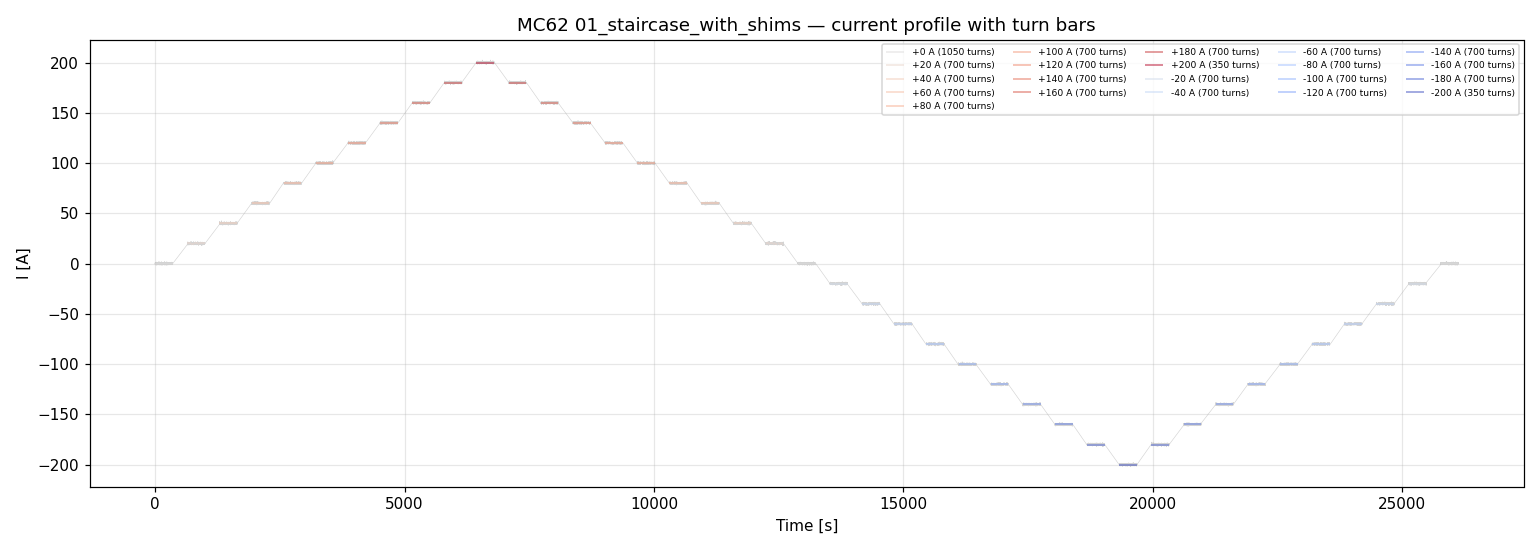

In [6]:
# ── Current profile with turn-bar overlay ──────────────────────────────
fig, ax = plt.subplots(figsize=(14, 5))

# Background: per-sample current (subsample for speed)
step = max(1, len(t_all_samples) // 80000)
ax.plot(t_all_samples[::step], I_all_samples[::step],
        linewidth=0.4, color="lightgrey", zorder=0)

# Colour palette per nominal current level
unique_I = sorted(df_turns["I_nom"].unique())
cmap = plt.cm.coolwarm
norm_c = plt.Normalize(min(unique_I), max(unique_I))
plateau_colors = {I: cmap(norm_c(I)) for I in unique_I}

# Draw each turn as a horizontal bar at its mean current
drawn_labels = set()
for _, row in df_turns.iterrows():
    I_nom = row["I_nom"]
    col = plateau_colors[I_nom]
    kw = {}
    lbl_key = f"{I_nom:+.0f} A"
    if lbl_key not in drawn_labels:
        n_at = int((df_turns["I_nom"] == I_nom).sum())
        kw["label"] = f"{lbl_key} ({n_at} turns)"
        drawn_labels.add(lbl_key)
    ax.plot([row["t_start"], row["t_end"]],
            [row["I_mean"], row["I_mean"]],
            linewidth=1.0, color=col, alpha=0.6,
            solid_capstyle="butt", zorder=2, **kw)

ax.set_xlabel("Time [s]")
ax.set_ylabel("I [A]")
ax.set_title("MC62 01_staircase_with_shims — current profile with turn bars")
ax.legend(loc="upper right", fontsize=6, ncol=5)
fig.tight_layout()
plt.show()

## 4. Process All Runs Through Kn Pipeline

Pipeline follows the Bottura standard (MTA-IN-97-007): drift → DFT → Kn →
centre location → feed-down → rotation → normalization → merge.

- **Integral**: `abs_upto_m_cmp_above` (B1 from absolute, n>1 from compensated)
- **Central**: `abs_all` (all from absolute — compensated SNR ≈ 3, unusable)

In [8]:
def load_and_process_runs(runs, kn, label, merge_mode="abs_upto_m_cmp_above"):
    all_rows = []

    # Channel detection from highest-current run
    peak_run = max(runs, key=lambda r: abs(r["I_nom"]))
    raw_peak = np.loadtxt(peak_run["file"])
    rr1 = robust_range(raw_peak[:, 1])
    rr2 = robust_range(raw_peak[:, 2])
    swap = rr2 > rr1
    print(f"[{label}] col1 range={rr1:.3e}, col2 range={rr2:.3e}"
          f"  ->  {'SWAP' if swap else 'no swap'}"
          f"  |  merge: {merge_mode}")

    # Hysteresis branch direction
    I_noms = [r["I_nom"] for r in runs]
    branches = ["ascending"]
    for i in range(1, len(I_noms)):
        if I_noms[i] > I_noms[i - 1]:
            branches.append("ascending")
        elif I_noms[i] < I_noms[i - 1]:
            branches.append("descending")
        else:
            branches.append(branches[-1])

    for ri, run_info in enumerate(runs):
        raw = np.loadtxt(run_info["file"])
        n_turns = raw.shape[0] // Ns
        raw = raw[: n_turns * Ns]

        t_turns  = raw[:, 0].reshape(n_turns, Ns)
        ch1      = raw[:, 1].reshape(n_turns, Ns)
        ch2      = raw[:, 2].reshape(n_turns, Ns)
        flux_abs = ch2 if swap else ch1
        flux_cmp = ch1 if swap else ch2
        # Column 3 is DCCT current (already in Amperes)
        I_turns  = raw[:, 3].reshape(n_turns, Ns)

        try:
            result, C_merged, C_units, ok_main = process_kn_pipeline(
                flux_abs, flux_cmp, t_turns, I_turns, kn, R_REF,
                MAGNET_ORDER,
                options=OPTIONS, drift_mode=DRIFT_MODE,
                min_b1_T=MIN_B1_T, max_zr=MAX_ZR,
                merge_mode=merge_mode,
            )
            extra = [{"run_id": run_info["run_id"],
                       "I_nom": run_info["I_nom"],
                       "branch": branches[ri],
                       "turn_in_run": t,
                       "pcb": label}
                      for t in range(n_turns)]
            rows = build_harmonic_rows(
                result, C_merged, C_units, ok_main,
                MAGNET_ORDER, extra)
            all_rows.extend(rows)
            n_ok = int(sum(ok_main))
            I_actual = I_turns.mean()
            print(f"  Run {run_info['run_id']:02d} "
                  f"(I_nom={run_info['I_nom']:+7.1f} A, "
                  f"I_meas={I_actual:+7.1f} A): "
                  f"{n_turns} turns, {n_ok} ok")
        except Exception as e:
            print(f"  Run {run_info['run_id']:02d} "
                  f"({run_info['I_nom']:+7.1f} A): FAILED - {e}")

    return pd.DataFrame(all_rows)

print("Processing Integral PCB (R45)...")
df_int = load_and_process_runs(runs_integral, kn_integral, "Integral")
print(f"\nProcessing Central PCB (DQ) — merge_mode='abs_all' (cmp SNR too low)...")
df_cen = load_and_process_runs(runs_central, kn_central, "Central",
                               merge_mode="abs_all")
print(f"\nIntegral: {len(df_int)} rows  |  Central: {len(df_cen)} rows")

Processing Integral PCB (R45)...


[Integral] col1 range=4.120e-03, col2 range=1.606e-04  ->  no swap  |  merge: abs_upto_m_cmp_above


  Run 00 (I_nom=   +0.0 A, I_meas=   +0.0 A): 350 turns, 350 ok


  Run 01 (I_nom=  +20.0 A, I_meas=  +20.0 A): 350 turns, 350 ok
  Run 02 (I_nom=  +40.0 A, I_meas=  +40.0 A): 350 turns, 350 ok


  Run 03 (I_nom=  +60.0 A, I_meas=  +60.0 A): 350 turns, 350 ok


  Run 04 (I_nom=  +80.0 A, I_meas=  +80.0 A): 350 turns, 350 ok


  Run 05 (I_nom= +100.0 A, I_meas= +100.0 A): 350 turns, 350 ok


  Run 06 (I_nom= +120.0 A, I_meas= +120.0 A): 350 turns, 350 ok


  Run 07 (I_nom= +140.0 A, I_meas= +140.0 A): 350 turns, 350 ok


  Run 08 (I_nom= +160.0 A, I_meas= +160.0 A): 350 turns, 350 ok


  Run 09 (I_nom= +180.0 A, I_meas= +180.0 A): 350 turns, 350 ok


  Run 10 (I_nom= +200.0 A, I_meas= +200.0 A): 350 turns, 350 ok


  Run 11 (I_nom= +180.0 A, I_meas= +180.0 A): 350 turns, 350 ok


  Run 12 (I_nom= +160.0 A, I_meas= +160.0 A): 350 turns, 350 ok


  Run 13 (I_nom= +140.0 A, I_meas= +140.0 A): 350 turns, 350 ok


  Run 14 (I_nom= +120.0 A, I_meas= +120.0 A): 350 turns, 350 ok


  Run 15 (I_nom= +100.0 A, I_meas= +100.0 A): 350 turns, 350 ok


  Run 16 (I_nom=  +80.0 A, I_meas=  +80.0 A): 350 turns, 350 ok


  Run 17 (I_nom=  +60.0 A, I_meas=  +60.0 A): 350 turns, 350 ok


  Run 18 (I_nom=  +40.0 A, I_meas=  +40.0 A): 350 turns, 350 ok


  Run 19 (I_nom=  +20.0 A, I_meas=  +20.0 A): 350 turns, 350 ok


  Run 20 (I_nom=   +0.0 A, I_meas=   +0.0 A): 350 turns, 350 ok


  Run 21 (I_nom=  -20.0 A, I_meas=  -20.0 A): 350 turns, 350 ok


  Run 22 (I_nom=  -40.0 A, I_meas=  -40.0 A): 350 turns, 350 ok


  Run 23 (I_nom=  -60.0 A, I_meas=  -60.0 A): 350 turns, 350 ok


  Run 24 (I_nom=  -80.0 A, I_meas=  -80.0 A): 350 turns, 350 ok


  Run 25 (I_nom= -100.0 A, I_meas= -100.0 A): 350 turns, 350 ok


  Run 26 (I_nom= -120.0 A, I_meas= -120.0 A): 350 turns, 350 ok


  Run 27 (I_nom= -140.0 A, I_meas= -140.0 A): 350 turns, 350 ok


  Run 28 (I_nom= -160.0 A, I_meas= -160.0 A): 350 turns, 350 ok


  Run 29 (I_nom= -180.0 A, I_meas= -180.0 A): 350 turns, 350 ok


  Run 30 (I_nom= -200.0 A, I_meas= -200.0 A): 350 turns, 350 ok


  Run 31 (I_nom= -180.0 A, I_meas= -180.0 A): 350 turns, 350 ok


  Run 32 (I_nom= -160.0 A, I_meas= -160.0 A): 350 turns, 350 ok


  Run 33 (I_nom= -140.0 A, I_meas= -140.0 A): 350 turns, 350 ok


  Run 34 (I_nom= -120.0 A, I_meas= -120.0 A): 350 turns, 350 ok


  Run 35 (I_nom= -100.0 A, I_meas= -100.0 A): 350 turns, 350 ok


  Run 36 (I_nom=  -80.0 A, I_meas=  -80.0 A): 350 turns, 350 ok


  Run 37 (I_nom=  -60.0 A, I_meas=  -60.0 A): 350 turns, 350 ok


  Run 38 (I_nom=  -40.0 A, I_meas=  -40.0 A): 350 turns, 350 ok


  Run 39 (I_nom=  -20.0 A, I_meas=  -20.0 A): 350 turns, 350 ok


  Run 40 (I_nom=   +0.0 A, I_meas=   +0.0 A): 350 turns, 350 ok

Processing Central PCB (DQ) — merge_mode='abs_all' (cmp SNR too low)...


[Central] col1 range=1.491e-04, col2 range=1.246e-07  ->  no swap  |  merge: abs_all


  Run 00 (I_nom=   +0.0 A, I_meas=   +0.0 A): 350 turns, 350 ok


  Run 01 (I_nom=  +20.0 A, I_meas=  +20.0 A): 350 turns, 350 ok


  Run 02 (I_nom=  +40.0 A, I_meas=  +40.0 A): 350 turns, 350 ok


  Run 03 (I_nom=  +60.0 A, I_meas=  +60.0 A): 350 turns, 350 ok


  Run 04 (I_nom=  +80.0 A, I_meas=  +80.0 A): 350 turns, 350 ok


  Run 05 (I_nom= +100.0 A, I_meas= +100.0 A): 350 turns, 350 ok


  Run 06 (I_nom= +120.0 A, I_meas= +120.0 A): 350 turns, 350 ok


  Run 07 (I_nom= +140.0 A, I_meas= +140.0 A): 350 turns, 350 ok


  Run 08 (I_nom= +160.0 A, I_meas= +160.0 A): 350 turns, 350 ok
  Run 09 (I_nom= +180.0 A, I_meas= +180.0 A): 350 turns, 350 ok


  Run 10 (I_nom= +200.0 A, I_meas= +200.0 A): 350 turns, 350 ok


  Run 11 (I_nom= +180.0 A, I_meas= +180.0 A): 350 turns, 350 ok
  Run 12 (I_nom= +160.0 A, I_meas= +160.0 A): 350 turns, 350 ok


  Run 13 (I_nom= +140.0 A, I_meas= +140.0 A): 350 turns, 350 ok
  Run 14 (I_nom= +120.0 A, I_meas= +120.0 A): 350 turns, 350 ok


  Run 15 (I_nom= +100.0 A, I_meas= +100.0 A): 350 turns, 350 ok


  Run 16 (I_nom=  +80.0 A, I_meas=  +80.0 A): 350 turns, 350 ok


  Run 17 (I_nom=  +60.0 A, I_meas=  +60.0 A): 350 turns, 350 ok


  Run 18 (I_nom=  +40.0 A, I_meas=  +40.0 A): 350 turns, 350 ok


  Run 19 (I_nom=  +20.0 A, I_meas=  +20.0 A): 350 turns, 350 ok


  Run 20 (I_nom=   +0.0 A, I_meas=   +0.0 A): 350 turns, 350 ok


  Run 21 (I_nom=  -20.0 A, I_meas=  -20.0 A): 350 turns, 350 ok


  Run 22 (I_nom=  -40.0 A, I_meas=  -40.0 A): 350 turns, 350 ok


  Run 23 (I_nom=  -60.0 A, I_meas=  -60.0 A): 350 turns, 350 ok


  Run 24 (I_nom=  -80.0 A, I_meas=  -80.0 A): 350 turns, 350 ok


  Run 25 (I_nom= -100.0 A, I_meas= -100.0 A): 350 turns, 350 ok


  Run 26 (I_nom= -120.0 A, I_meas= -120.0 A): 350 turns, 350 ok


  Run 27 (I_nom= -140.0 A, I_meas= -140.0 A): 350 turns, 350 ok


  Run 28 (I_nom= -160.0 A, I_meas= -160.0 A): 350 turns, 350 ok


  Run 29 (I_nom= -180.0 A, I_meas= -180.0 A): 350 turns, 350 ok


  Run 30 (I_nom= -200.0 A, I_meas= -200.0 A): 350 turns, 350 ok


  Run 31 (I_nom= -180.0 A, I_meas= -180.0 A): 350 turns, 350 ok
  Run 32 (I_nom= -160.0 A, I_meas= -160.0 A): 350 turns, 350 ok


  Run 33 (I_nom= -140.0 A, I_meas= -140.0 A): 350 turns, 350 ok


  Run 34 (I_nom= -120.0 A, I_meas= -120.0 A): 350 turns, 350 ok


  Run 35 (I_nom= -100.0 A, I_meas= -100.0 A): 350 turns, 350 ok


  Run 36 (I_nom=  -80.0 A, I_meas=  -80.0 A): 350 turns, 350 ok


  Run 37 (I_nom=  -60.0 A, I_meas=  -60.0 A): 350 turns, 350 ok


  Run 38 (I_nom=  -40.0 A, I_meas=  -40.0 A): 350 turns, 350 ok


  Run 39 (I_nom=  -20.0 A, I_meas=  -20.0 A): 350 turns, 350 ok


  Run 40 (I_nom=   +0.0 A, I_meas=   +0.0 A): 350 turns, 350 ok

Integral: 14350 rows  |  Central: 14350 rows


## 5. Plateau Quality & Averaging

Select the **last N turns** per plateau (to let eddy currents settle).
Flag plateaus as *good* or *bad* based on `ok_main`.

In [9]:
def plateau_summary(df, n_last):
    records = []
    for run_id in sorted(df["run_id"].unique()):
        rdf = df[df["run_id"] == run_id].sort_values("turn_in_run")
        sel = rdf.tail(n_last)
        ok = sel["ok_main"].astype(bool)

        rec = {
            "run_id": run_id,
            "I_nom": sel["I_nom"].iloc[0],
            "branch": sel["branch"].iloc[0],
            "n_total": len(rdf),
            "n_selected": len(sel),
            "n_ok": int(ok.sum()),
        }

        # B1 in Tesla
        if ok.any():
            rec["B1_mean"] = sel.loc[ok, "B1_T"].mean()
            rec["B1_std"]  = sel.loc[ok, "B1_T"].std() if ok.sum() > 1 else 0.0
        else:
            rec["B1_mean"] = np.nan
            rec["B1_std"]  = np.nan

        # Higher harmonics in units
        for h in range(2, 16):
            for prefix in ["b", "a"]:
                col = f"{prefix}{h}_units"
                key_m = f"{col}_mean"
                key_s = f"{col}_std"
                if col in sel.columns and ok.any():
                    vals = sel.loc[ok, col]
                    rec[key_m] = vals.mean()
                    rec[key_s] = vals.std() if ok.sum() > 1 else 0.0
                else:
                    rec[key_m] = np.nan
                    rec[key_s] = np.nan

        # Transfer function (T/kA)
        if ok.any() and abs(rec["I_nom"]) > 1.0:
            rec["TF"] = rec["B1_mean"] / (rec["I_nom"] / 1000.0)
        else:
            rec["TF"] = np.nan

        rec["quality"] = "good" if rec["n_ok"] >= max(1, n_last // 2) else "bad"
        records.append(rec)

    return pd.DataFrame(records)

summ_int = plateau_summary(df_int, N_LAST_TURNS)
summ_cen = plateau_summary(df_cen, N_LAST_TURNS)

cols_show = ["run_id", "I_nom", "branch", "n_ok",
             "B1_mean", "B1_std", "quality"]
print("=== Integral PCB (R45) ===")
print(summ_int[cols_show].to_string(index=False, float_format="%.6f"))
print(f"\n=== Central PCB (DQ) ===")
print(summ_cen[cols_show].to_string(index=False, float_format="%.6f"))

=== Integral PCB (R45) ===
 run_id       I_nom     branch  n_ok   B1_mean   B1_std quality
      0    0.000000  ascending   170  0.000306 0.000005    good
      1   20.000000  ascending   170 -0.026867 0.000009    good
      2   40.000000  ascending   170 -0.054110 0.000013    good
      3   60.000000  ascending   170 -0.081354 0.000017    good
      4   80.000000  ascending   170 -0.108548 0.000018    good
      5  100.000000  ascending   170 -0.135640 0.000017    good
      6  120.000000  ascending   170 -0.162428 0.000015    good
      7  140.000000  ascending   170 -0.186459 0.000016    good
      8  160.000000  ascending   170 -0.204377 0.000018    good
      9  180.000000  ascending   170 -0.218622 0.000018    good
     10  200.000000  ascending   170 -0.230320 0.000019    good
     11  180.000000 descending   170 -0.219178 0.000018    good
     12  160.000000 descending   170 -0.205206 0.000016    good
     13  140.000000 descending   170 -0.187466 0.000016    good
     14  120.

## 6. Eddy-Current Settling — B1 vs Turn Number

Turn-by-turn evolution within each plateau.  With 350 turns per run,
only the first 30 turns are shown to highlight the settling region.

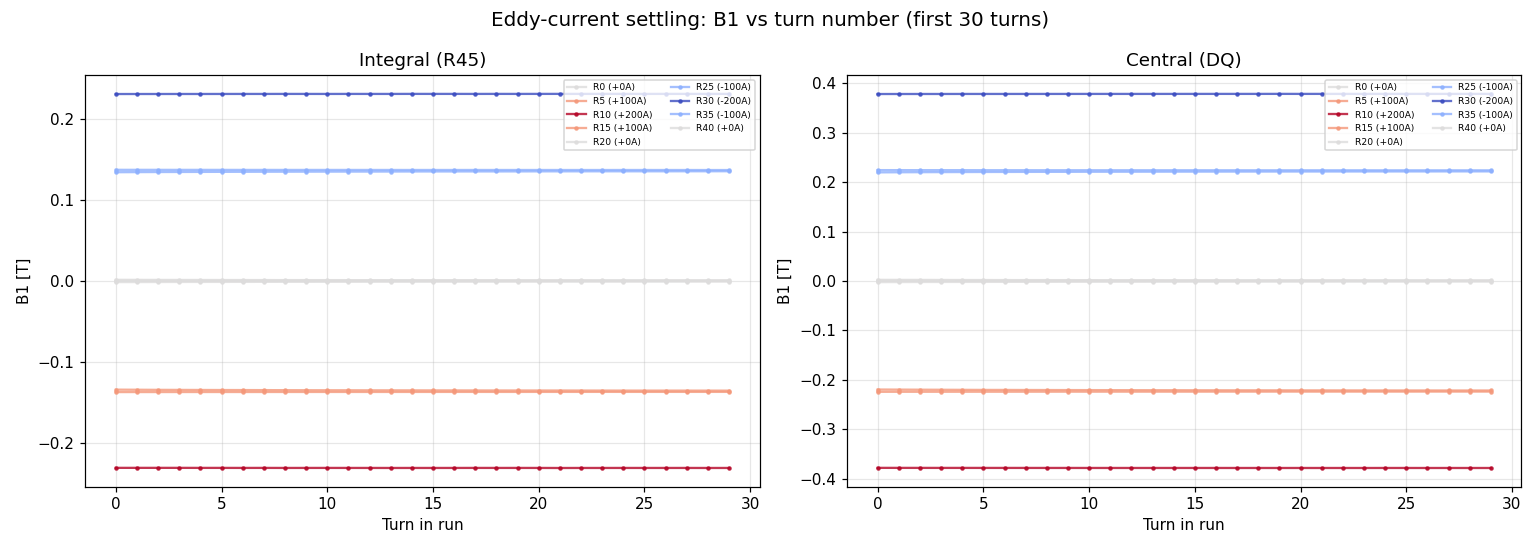

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, df, label in [(axes[0], df_int, "Integral (R45)"),
                       (axes[1], df_cen, "Central (DQ)")]:
    cmap = plt.cm.coolwarm
    all_runs = sorted(df["run_id"].unique())
    I_min = df["I_nom"].min()
    I_max = df["I_nom"].max()
    norm = plt.Normalize(I_min, I_max)

    # Show a subset of runs for clarity
    show_runs = [0, 5, 10, 15, 20, 25, 30, 35, 40]
    for run_id in show_runs:
        rdf = df[df["run_id"] == run_id].sort_values("turn_in_run")
        ok = rdf["ok_main"].astype(bool)
        if not ok.any():
            continue
        I_nom = rdf["I_nom"].iloc[0]
        color = cmap(norm(I_nom))
        # Show first 30 turns only
        first30 = rdf[rdf["turn_in_run"] < 30]
        ok30 = first30["ok_main"].astype(bool)
        if ok30.any():
            ax.plot(first30.loc[ok30, "turn_in_run"],
                    first30.loc[ok30, "B1_T"],
                    "o-", ms=2, color=color, alpha=0.8,
                    label=f"R{run_id} ({I_nom:+.0f}A)")

    ax.set_xlabel("Turn in run")
    ax.set_ylabel("B1 [T]")
    ax.set_title(label)
    ax.legend(fontsize=6, ncol=2)

fig.suptitle("Eddy-current settling: B1 vs turn number (first 30 turns)", fontsize=13)
fig.tight_layout()
plt.show()

## 7. B1 (Main Dipole Field) vs Current — Hysteresis

Averaged over last N turns.  **Blue** = ascending, **Red** = descending.
Line shading: light/thin = start of measurement, dark/thick = end.

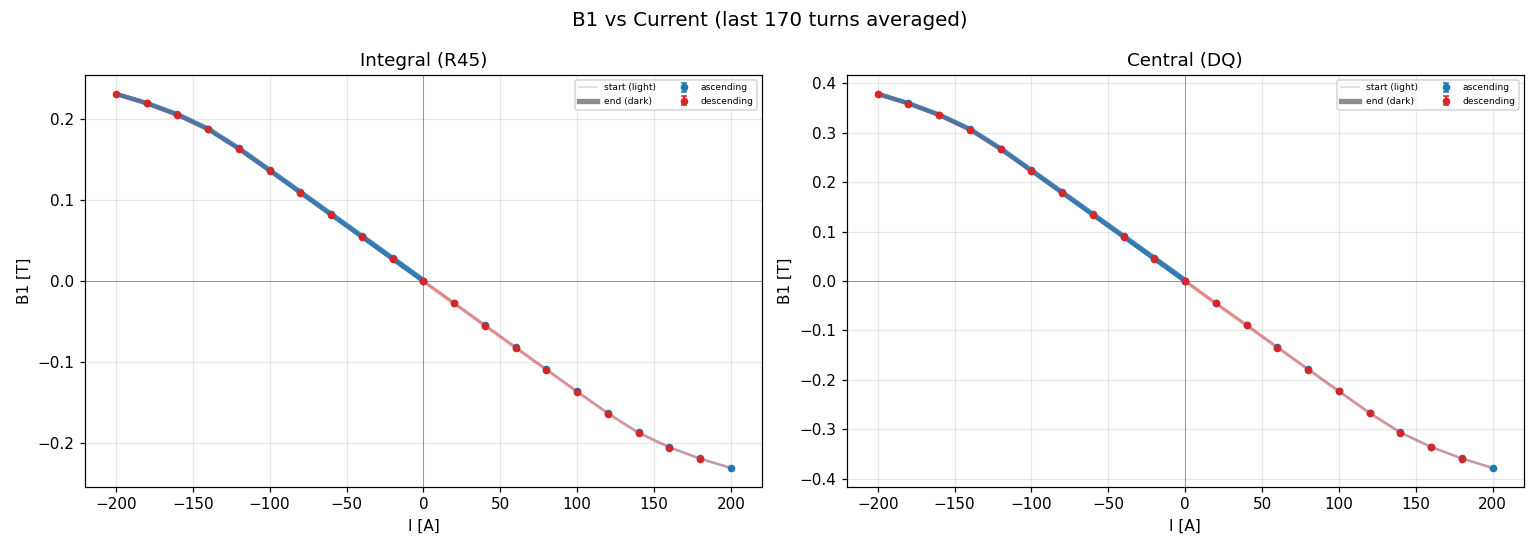

In [11]:
branch_colors = {"ascending": "tab:blue", "descending": "tab:red"}

def plot_hysteresis(ax, summ, xcol, ycol, yerr_col=None):
    s = summ.sort_values("run_id")

    # -- gradient segments: light → dark along measurement order --
    valid = (s["quality"] == "good") & s[ycol].notna()
    if valid.sum() > 1:
        sv = s[valid].reset_index(drop=True)
        xg = sv[xcol].values
        yg = sv[ycol].values
        n = len(xg)

        for i in range(n - 1):
            frac = i / max(n - 2, 1)
            alpha = 0.15 + 0.75 * frac
            lw = 1.0 + 2.5 * frac
            br = sv["branch"].iloc[i + 1]
            col = branch_colors.get(br, "grey")
            ax.plot([xg[i], xg[i + 1]], [yg[i], yg[i + 1]],
                    "-", color=col, lw=lw, alpha=alpha,
                    solid_capstyle="round", zorder=2)

    # -- data points with error bars, coloured by branch --
    for br, col in branch_colors.items():
        good = ((s["branch"] == br)
                & (s["quality"] == "good")
                & s[ycol].notna())
        if good.any():
            kw = dict(yerr=s.loc[good, yerr_col]) if yerr_col else {}
            ax.errorbar(s.loc[good, xcol], s.loc[good, ycol],
                        fmt="o", color=col, ms=4, capsize=2,
                        label=br, zorder=4, **kw)
        bad = ((s["branch"] == br)
               & (s["quality"] == "bad")
               & s[ycol].notna())
        if bad.any():
            ax.scatter(s.loc[bad, xcol], s.loc[bad, ycol],
                       marker="x", s=60, color=col, alpha=0.5,
                       label=f"{br} (bad)", zorder=4)

    ax.plot([], [], "-", color="grey", lw=1, alpha=0.3, label="start (light)")
    ax.plot([], [], "-", color="grey", lw=3.5, alpha=0.9, label="end (dark)")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, summ, label in [(axes[0], summ_int, "Integral (R45)"),
                          (axes[1], summ_cen, "Central (DQ)")]:
    plot_hysteresis(ax, summ, "I_nom", "B1_mean", "B1_std")
    ax.set_xlabel("I [A]")
    ax.set_ylabel("B1 [T]")
    ax.set_title(label)
    ax.legend(fontsize=6, ncol=2)
    ax.axhline(0, color="gray", lw=0.5)
    ax.axvline(0, color="gray", lw=0.5)

fig.suptitle(f"B1 vs Current (last {N_LAST_TURNS} turns averaged)",
             fontsize=13)
fig.tight_layout()
plt.show()

## 8. b2 (Quadrupole) vs Current

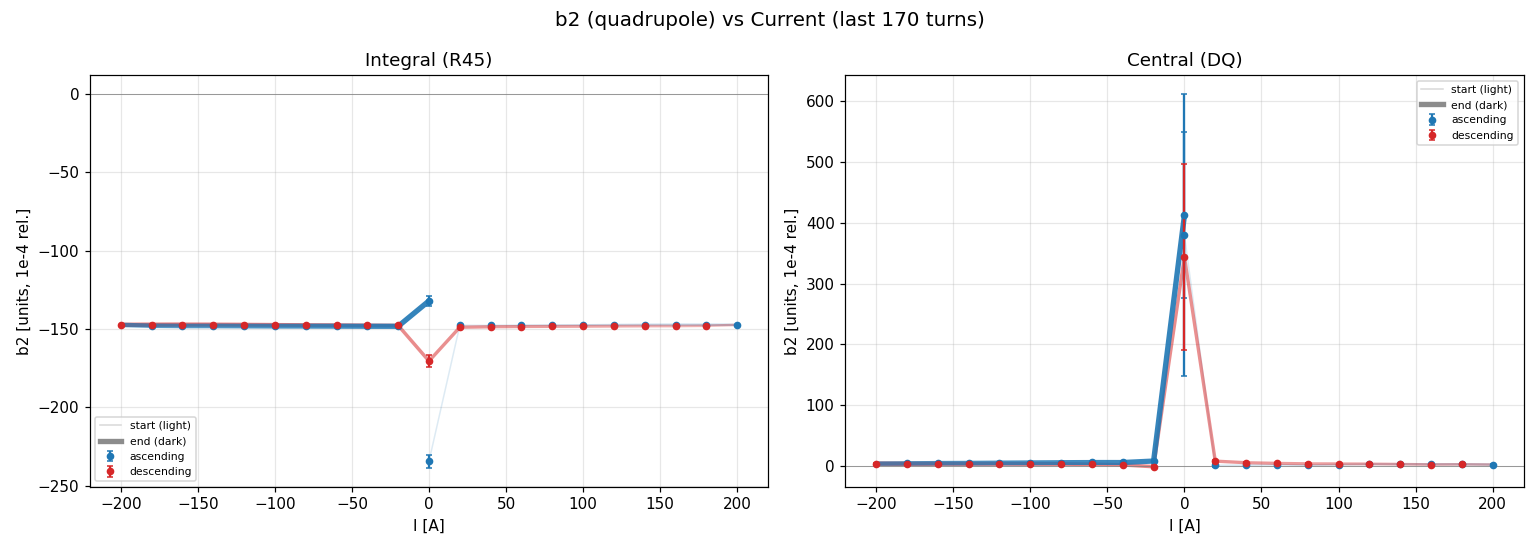

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, summ, label in [(axes[0], summ_int, "Integral (R45)"),
                          (axes[1], summ_cen, "Central (DQ)")]:
    plot_hysteresis(ax, summ, "I_nom", "b2_units_mean", "b2_units_std")
    ax.set_xlabel("I [A]")
    ax.set_ylabel("b2 [units, 1e-4 rel.]")
    ax.set_title(label)
    ax.legend(fontsize=7)
    ax.axhline(0, color="gray", lw=0.5)

fig.suptitle(f"b2 (quadrupole) vs Current (last {N_LAST_TURNS} turns)",
             fontsize=13)
fig.tight_layout()
plt.show()

## 9. b3 (Sextupole) vs Current

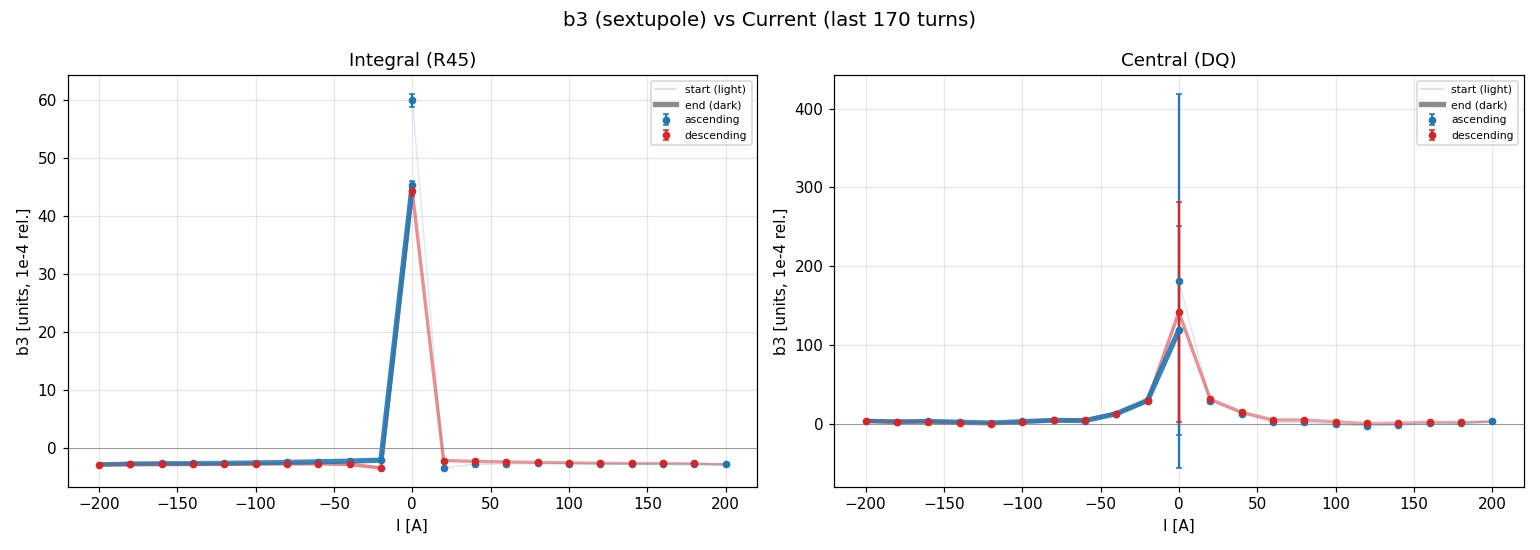

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, summ, label in [(axes[0], summ_int, "Integral (R45)"),
                          (axes[1], summ_cen, "Central (DQ)")]:
    plot_hysteresis(ax, summ, "I_nom", "b3_units_mean", "b3_units_std")
    ax.set_xlabel("I [A]")
    ax.set_ylabel("b3 [units, 1e-4 rel.]")
    ax.set_title(label)
    ax.legend(fontsize=7)
    ax.axhline(0, color="gray", lw=0.5)

fig.suptitle(f"b3 (sextupole) vs Current (last {N_LAST_TURNS} turns)",
             fontsize=13)
fig.tight_layout()
plt.show()

## 10. Transfer Function  B1 / I  vs I

Excludes 0 A runs (undefined).  Saturation appears as a drop in TF at
high |I|.  The staircase gives a detailed TF curve vs current.

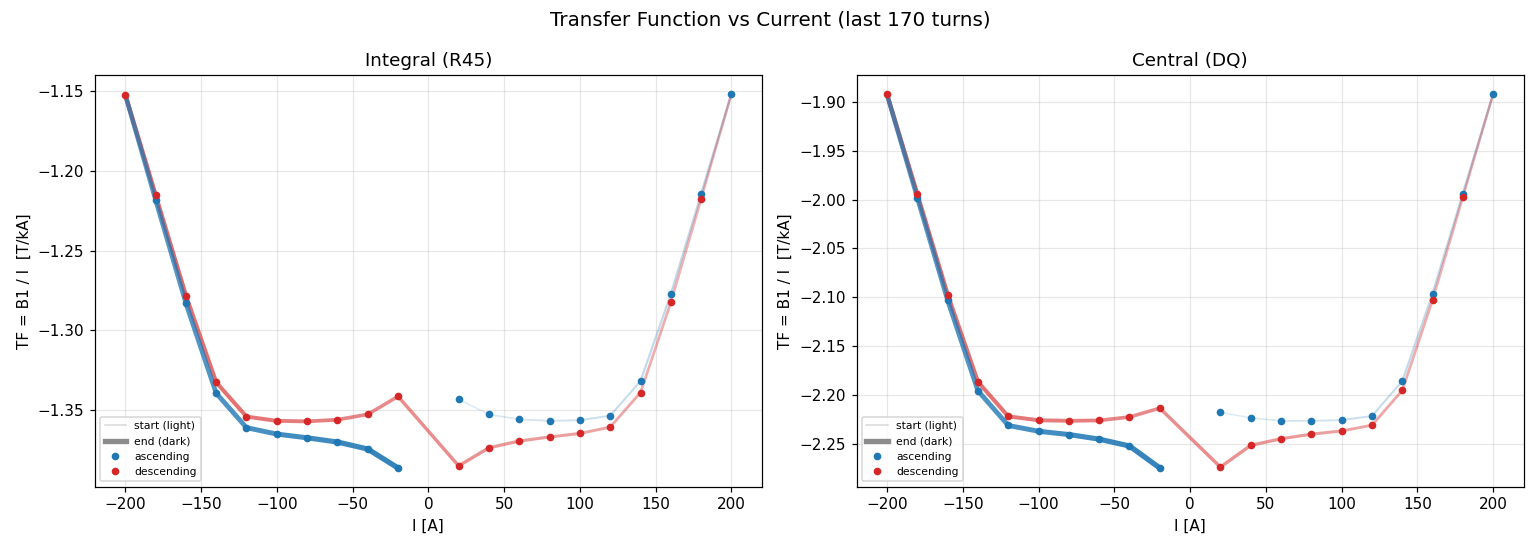

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, summ, label in [(axes[0], summ_int, "Integral (R45)"),
                          (axes[1], summ_cen, "Central (DQ)")]:
    plot_hysteresis(ax, summ, "I_nom", "TF")
    ax.set_xlabel("I [A]")
    ax.set_ylabel("TF = B1 / I  [T/kA]")
    ax.set_title(label)
    ax.legend(fontsize=7)

fig.suptitle(f"Transfer Function vs Current (last {N_LAST_TURNS} turns)",
             fontsize=13)
fig.tight_layout()
plt.show()

## 11. Multipole Spectrum at Peak Current

Bar chart of normal (bn) and skew (an) harmonics at the
highest-current good plateau.

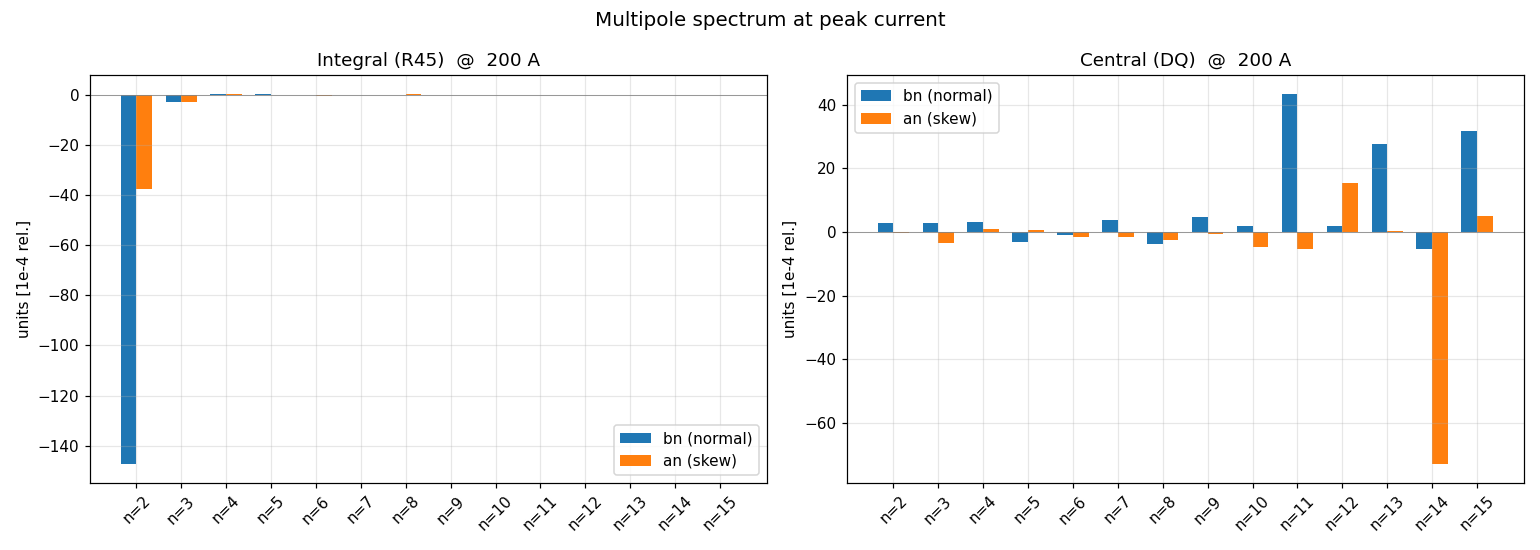

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, summ, label in [(axes[0], summ_int, "Integral (R45)"),
                          (axes[1], summ_cen, "Central (DQ)")]:
    good = summ[summ["quality"] == "good"]
    if good.empty:
        ax.set_title(f"{label}: no valid data")
        continue
    peak = good.loc[good["I_nom"].abs().idxmax()]

    orders, bn, an = [], [], []
    for n in range(2, 16):
        bc = f"b{n}_units_mean"
        ac = f"a{n}_units_mean"
        if bc in summ.columns and pd.notna(peak.get(bc)):
            orders.append(n)
            bn.append(peak[bc])
            an.append(peak.get(ac, 0.0) if pd.notna(peak.get(ac)) else 0.0)

    if orders:
        x = np.arange(len(orders))
        w = 0.35
        ax.bar(x - w / 2, bn, w, label="bn (normal)", color="tab:blue")
        ax.bar(x + w / 2, an, w, label="an (skew)", color="tab:orange")
        ax.set_xticks(x)
        ax.set_xticklabels([f"n={o}" for o in orders], rotation=45)
        ax.set_ylabel("units [1e-4 rel.]")
        ax.set_title(f"{label}  @  {peak['I_nom']:.0f} A")
        ax.legend()
        ax.axhline(0, color="gray", lw=0.5)

fig.suptitle("Multipole spectrum at peak current", fontsize=13)
fig.tight_layout()
plt.show()

## 12. Summary Table

In [16]:
def format_summary(summ, label):
    print(f"\n{'=' * 85}")
    print(f"  {label}")
    print(f"  R_ref = {R_REF*1e3:.1f} mm  |  "
          f"last {N_LAST_TURNS} turns averaged")
    print(f"{'=' * 85}")
    hdr = (f"{'Run':>4s} {'I [A]':>8s} {'Branch':>10s} "
           f"{'B1 [T]':>12s} {'b2 [units]':>12s} "
           f"{'b3 [units]':>12s} {'TF [T/kA]':>10s} {'Qual':>5s}")
    print(hdr)
    print("-" * 85)
    for _, r in summ.iterrows():
        b1 = f"{r['B1_mean']:.6f}" if pd.notna(r['B1_mean']) else "---"
        b2 = (f"{r.get('b2_units_mean', np.nan):.2f}"
              if pd.notna(r.get('b2_units_mean')) else "---")
        b3 = (f"{r.get('b3_units_mean', np.nan):.2f}"
              if pd.notna(r.get('b3_units_mean')) else "---")
        tf = f"{r['TF']:.4f}" if pd.notna(r['TF']) else "---"
        print(f"{r['run_id']:4.0f} {r['I_nom']:+8.1f} "
              f"{r['branch']:>10s} {b1:>12s} {b2:>12s} "
              f"{b3:>12s} {tf:>10s} {r['quality']:>5s}")

format_summary(summ_int, "Integral PCB (R45)")
format_summary(summ_cen, "Central PCB (DQ)")


  Integral PCB (R45)
  R_ref = 33.0 mm  |  last 170 turns averaged
 Run    I [A]     Branch       B1 [T]   b2 [units]   b3 [units]  TF [T/kA]  Qual
-------------------------------------------------------------------------------------
   0     +0.0  ascending     0.000306      -234.39        59.90        ---  good
   1    +20.0  ascending    -0.026867      -147.67        -3.50    -1.3433  good
   2    +40.0  ascending    -0.054110      -147.78        -2.88    -1.3528  good
   3    +60.0  ascending    -0.081354      -147.67        -2.74    -1.3559  good
   4    +80.0  ascending    -0.108548      -147.59        -2.73    -1.3568  good
   5   +100.0  ascending    -0.135640      -147.49        -2.76    -1.3564  good
   6   +120.0  ascending    -0.162428      -147.37        -2.80    -1.3536  good
   7   +140.0  ascending    -0.186459      -147.28        -2.83    -1.3319  good
   8   +160.0  ascending    -0.204377      -147.25        -2.83    -1.2774  good
   9   +180.0  ascending    -0.21862

## 13. Export to CSV (optional)

In [17]:
# Uncomment to save:
# out = Path(r"C:\Users\albellel\python-projects\rotating-coil-analyzer\output")
# out.mkdir(exist_ok=True)
# summ_int.to_csv(out / "MC62_01_staircase_with_shims_integral_summary.csv", index=False)
# summ_cen.to_csv(out / "MC62_01_staircase_with_shims_central_summary.csv", index=False)
# df_int.to_csv(out / "MC62_01_staircase_with_shims_integral_all_turns.csv", index=False)
# df_cen.to_csv(out / "MC62_01_staircase_with_shims_central_all_turns.csv", index=False)
# print("Saved to", out)